In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [3]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [4]:
comp = [
     #'England'
     'France',
     #'Germany',
     #'Italy',
     #'Spain'
]

In [5]:
##DA qui

In [6]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [7]:
selected_competitions = competitions[(competitions['country_name'] =='France')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
3,412,181189,France,French first division,male,2017/2018


### Append home and away goals to the game dataset

In [8]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [9]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [10]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [11]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181189,2501056,"Caen - PSG, 0 - 0",412,0,0
1,181189,2501057,"Dijon - Angers SCO, 2 - 1",412,2,1
2,181189,2501058,"Olympique Lyonnais - Nice, 3 - 2",412,3,2
3,181189,2501059,"Olympique Marseille - Amiens SC, 2 - 1",412,2,1
4,181189,2501060,"Metz - Bordeaux, 0 - 4",412,0,4


In [12]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [13]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2501056,412,181189,2018-05-19 19:00:00,38,3783,3767
1,2501057,412,181189,2018-05-19 19:00:00,38,3804,3799
2,2501058,412,181189,2018-05-19 19:00:00,38,3766,3775
3,2501059,412,181189,2018-05-19 19:00:00,38,3771,3789
4,2501060,412,181189,2018-05-19 19:00:00,38,3777,3772


In [14]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [15]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,3783,3767,2018-05-19 19:00:00,0,0
1,3804,3799,2018-05-19 19:00:00,2,1
2,3766,3775,2018-05-19 19:00:00,3,2
3,3771,3789,2018-05-19 19:00:00,2,1
4,3777,3772,2018-05-19 19:00:00,0,4
...,...,...,...,...,...
375,3787,3783,2017-08-05 18:00:00,1,0
376,3782,3775,2017-08-05 18:00:00,1,0
377,3795,3774,2017-08-05 18:00:00,1,1
378,3767,3789,2017-08-05 15:15:00,2,0


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


### Convert event to actions

# DO NOT RUN

In [17]:
### DO NOT RUN
#Convert events to SPADL 
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
atomic_actions = {}

for game in games_verbose:
    # load data
    teams.append(wyscout.teams(game.game_id))
    players.append(wyscout.players(game.game_id))
    events = wyscout.events(game.game_id)
    # convert data
    actions[game.game_id] = convert_to_actions(events, game.home_team_id)
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions[game.game_id])

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 380/380 [2:05:54<00:00, 19.88s/it]  


In [18]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Fra"

In [19]:
# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = atomic_actions[game_id]

In [20]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [21]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,3783,Caen,Stade Malherbe Caen
1,3767,PSG,Paris Saint-Germain FC
2,3804,Dijon,Dijon FCO
3,3799,Angers,Angers SCO
4,3766,Olympique Lyonnais,Olympique Lyonnais
5,3775,Nice,O.G.C. Nice C\u00f4te d'Azur
6,3771,Olympique Marseille,Olympique de Marseille
7,3789,Amiens SC,Amiens SC
8,3772,Bordeaux,FC Girondins de Bordeaux
9,3777,Metz,FC Metz


In [23]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "France") 
                  & (games.home_team_name_short == "PSG")
                  & (games.away_team_name_short== "Monaco")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2501012,243285637,0,1,1.956679,19830,3450,52.50,33.32,5.25,-2.72,0,0,pass,foot,R. Falcao,Monaco,AS Monaco FC
1,2501012,243285637,1,1,3.370761,19830,28922,57.75,30.60,0.00,0.00,23,0,receival,foot,T. Lemar,Monaco,AS Monaco FC
2,2501012,243285639,2,1,4.784843,19830,28922,57.75,30.60,7.35,-10.20,0,0,pass,foot,T. Lemar,Monaco,AS Monaco FC
3,2501012,243285639,3,1,5.807595,19830,207143,65.10,20.40,0.00,0.00,23,0,receival,foot,Fabinho,Monaco,AS Monaco FC
4,2501012,243285640,4,1,6.830347,19830,207143,65.10,20.40,13.65,8.16,0,0,pass,foot,Fabinho,Monaco,AS Monaco FC


2018-04-15 19:00:00, Paris Saint-Germain FC - AS Monaco FC : 7-1 , Á. di María 20'


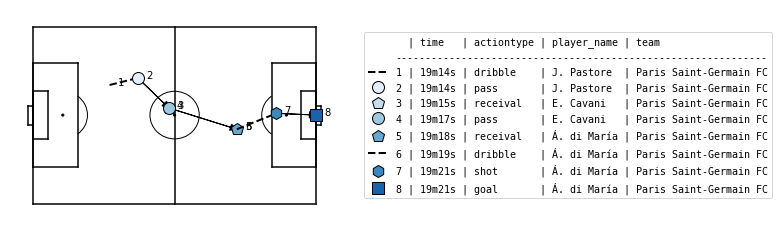

In [26]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [27]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [28]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [29]:
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:
    for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        gamestates = fs.gamestates(atomicspadl.add_names(actions), 3)
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
        featurestore[f"game_{game.game_id}"] = X

Generating and storing features in /Users/leonardoyang/Desktop/data-fifa/Fra/atomic_features.h5: 100%|██████████| 380/380 [01:37<00:00,  3.92it/s]


In [30]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y


Computing and storing labels in /Users/leonardoyang/Desktop/data-fifa/Fra/atomic_labels.h5: 100%|██████████| 380/380 [01:40<00:00,  3.76it/s]


### Compute Probabilities

In [31]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [32]:
traingames, testgames = train_test_split(games, test_size=0.3, random_state=42, shuffle=False)

In [33]:
testgames

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
266,2500800,412,181189,2017-11-04 19:00:00,12,3787,3789,1,1
267,2500801,412,181189,2017-11-04 19:00:00,12,3770,3780,2,1
268,2500805,412,181189,2017-11-04 19:00:00,12,3795,3779,3,0
269,2500796,412,181189,2017-11-04 16:00:00,12,3799,3767,0,5
270,2500803,412,181189,2017-11-03 19:45:00,12,3774,3772,1,0
...,...,...,...,...,...,...,...,...,...
375,2500692,412,181189,2017-08-05 18:00:00,1,3787,3783,1,0
376,2500694,412,181189,2017-08-05 18:00:00,1,3782,3775,1,0
377,2500695,412,181189,2017-08-05 18:00:00,1,3795,3774,1,1
378,2500693,412,181189,2017-08-05 15:15:00,1,3767,3789,2,0


In [34]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 1

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X,Y = getXY(traingames, Xcols)
#print("X:", list(X.columns))
#print("Y:", list(Y.columns))
X = X.fillna(0)

Selecting label: 100%|██████████| 266/266 [00:03<00:00, 75.18it/s]


## Train 

In [35]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier(n_estimators=48, max_depth=3, n_jobs=-3, verbosity=1)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 4min 17s, sys: 2.92 s, total: 4min 20s
Wall time: 1min 20s


In [36]:
testX, testY = getXY(testgames,Xcols)

Selecting label: 100%|██████████| 114/114 [00:01<00:00, 91.84it/s]


In [37]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])


### Y: scores ###
  Brier score: 0.00821 (0.83166)
  log loss score: 0.04175 (0.74728)
  ROC AUC: 0.84884
### Y: concedes ###
  Brier score: 0.00156 (0.87533)
  log loss score: 0.01018 (0.77649)
  ROC AUC: 0.82685


In [38]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 114/114 [00:01<00:00, 74.90it/s]


## VAEP

In [39]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(testgames))

nb of games: 114


In [40]:
A = []
for game in tqdm.tqdm(list(testgames.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 114/114 [00:08<00:00, 13.10it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [41]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:20]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
38,21174,E. Cavani,14.332939,14.237800,0.095140,468
221,40810,Neymar,11.358932,11.052524,0.306407,1335
12,3450,R. Falcao,11.312092,11.160441,0.151651,523
180,28115,N. Fekir,9.894455,9.942846,-0.048391,1062
17,5167,Mariano Díaz,9.430831,9.239781,0.191049,489
386,300485,Malcom,9.152671,8.791034,0.361638,1410
171,26638,K. Toko Ekambi,7.957328,7.695527,0.261801,749
412,353833,K. Mbappé,7.929224,7.801422,0.127802,777
115,25930,M. Samassa,6.887496,0.512406,6.375091,656
41,25382,A. Lopes,6.436044,0.759569,5.676475,631


In [42]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1500] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
220,40810,Neymar,11.358932,11.052524,0.306407,1335,1862,0.549035,0.534225,0.014810
37,21174,E. Cavani,14.332939,14.237800,0.095140,468,2681,0.481150,0.477957,0.003194
11,3450,R. Falcao,11.312092,11.160441,0.151651,523,2212,0.460257,0.454087,0.006170
179,28115,N. Fekir,9.894455,9.942846,-0.048391,1062,2618,0.340146,0.341809,-0.001664
16,5167,Mariano Díaz,9.430831,9.239781,0.191049,489,2617,0.324331,0.317761,0.006570
389,301635,B. Kamara,6.255069,0.435326,5.819744,666,1770,0.318054,0.022135,0.295919
411,353833,K. Mbappé,7.929224,7.801422,0.127802,777,2255,0.316466,0.311365,0.005101
114,25930,M. Samassa,6.887496,0.512406,6.375091,656,1993,0.311026,0.023139,0.287887
385,300485,Malcom,9.152671,8.791034,0.361638,1410,2978,0.276609,0.265679,0.010929
158,26389,Y. Sankharé,5.969448,5.435550,0.533898,1191,1984,0.270791,0.246572,0.024219


In [43]:
stats.sort_values("defensive_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
389,301635,B. Kamara,6.255069,0.435326,5.819744,666,1770,0.318054,0.022135,0.295919
114,25930,M. Samassa,6.887496,0.512406,6.375091,656,1993,0.311026,0.023139,0.287887
212,37896,E. Kawashima,5.633955,0.305536,5.328420,297,2698,0.187938,0.010192,0.177746
69,25552,S. Mandanda,5.497416,0.480575,5.016841,538,2809,0.176137,0.015398,0.160739
40,25382,A. Lopes,6.436044,0.759569,5.676475,631,3215,0.180169,0.021263,0.158906
106,25845,S. Ruffier,5.807782,0.389686,5.418095,630,3163,0.165255,0.011088,0.154166
167,26583,R. Gurtner,5.798329,0.529030,5.269300,663,3509,0.148717,0.013569,0.135149
226,50771,K. Johnsson,5.648167,0.434812,5.213354,617,3586,0.141755,0.010913,0.130843
41,25384,R. Vercoutre,5.161480,0.657049,4.504431,607,3250,0.142933,0.018195,0.124738
77,25632,B. Costil,5.133394,0.431908,4.701486,714,3410,0.135485,0.011399,0.124086
